# Density estimation with Normalizing Flow

## Toy example

Use variables $\alpha$ and $\beta$ to define SR.

$$
p(\alpha) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\alpha^{2}}{2}}
$$

$$
p(\beta) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\beta^{2}}{2}}
$$

Use variable $y$ which has a weak dependence on $\alpha$ and $\beta$ for training and likelihood fitting.

$$
y = N( \mu = k\alpha + q\beta,\sigma = 1)
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from tqdm import tqdm

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda:0" if CUDA else "cpu")

cuda available: True


In [130]:
%run plotting.py

<function matplotlib.pyplot.close(fig=None)>

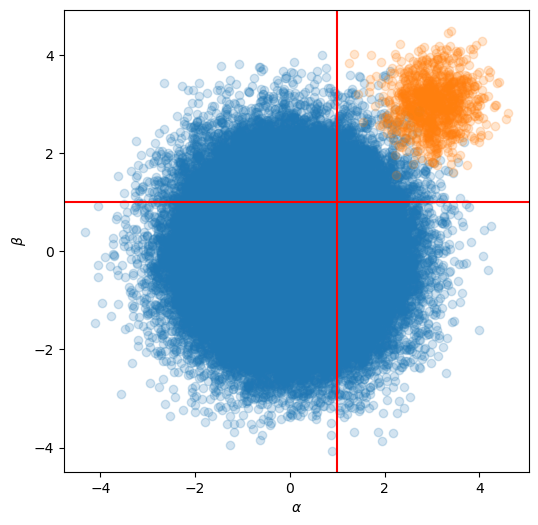

In [3]:
n1 = 100000
plt.figure(figsize=(6,6))
# Background
x1 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
x2 = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.scatter(x1, x2, alpha = 0.2)
data = np.stack([x1, x2], axis = -1)
# Signal
n2 = 1000
x3 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
x4 = np.random.normal(3, 0.5, n2).astype(dtype=np.float32)
plt.scatter(x3, x4, alpha = 0.2)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.show
plt.savefig('plots/full_bkg_sig.pdf')
plt.close

Blues shows the background events, and orange shows the signal events. The red lines define the CRs and SR. The upper right region is SR.

### Define the training model

In [4]:
%run SimpleMAF.py

### Generate the 2D gaussian distribution.

In [5]:
MAF1 = SimpleMAF(num_features = data.ndim)
MAF1.train(data, n_epochs=20, plot=False)

100%|==========| 20/20 [00:33<00:00,  1.66s/it]


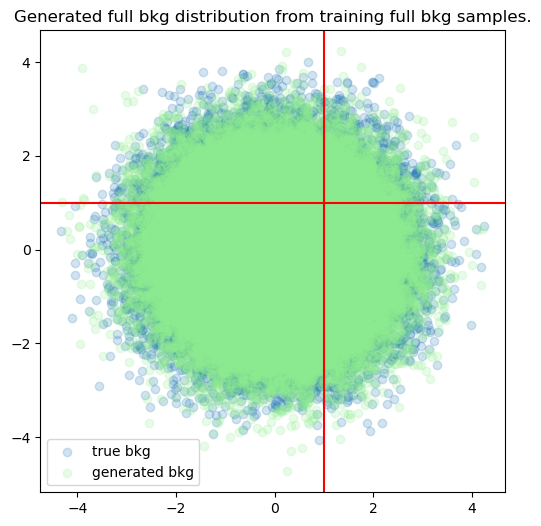

In [6]:
samples_gen_full_bkg = MAF1.sample(n1)
plot_gen_full_bkg(samples_gen_full_bkg, x1, x2)

In [7]:
# Train on background distribution in CR
mask_CR = np.logical_not((data[:,0] > 1) & (data[:,1] > 1))
# Generate background distribution in SR
mask_SR = (x1 > 1) & (x2 > 1)

<function matplotlib.pyplot.close(fig=None)>

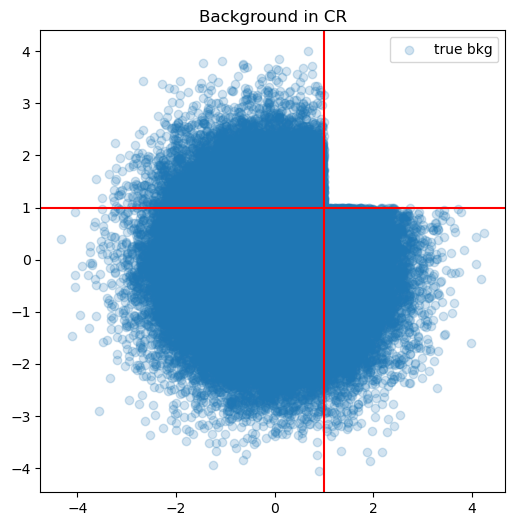

In [8]:
# Plot partial background that's been trained on
x1_CR = data[mask_CR][:,0]
x2_CR = data[mask_CR][:,1]
plt.figure(figsize=(6,6))
plt.scatter(x1_CR, x2_CR, alpha = 0.2, label = 'true bkg')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.title("Background in CR")
plt.legend()
plt.show
plt.savefig('plots/train_CR_bkg.pdf')
plt.close

In [9]:
MAF2 = SimpleMAF(num_features = 2, num_cond_features = 2)
MAF2.train(data[mask_CR], cond=data[mask_CR], n_epochs=20, plot=False)

100%|==========| 20/20 [00:37<00:00,  1.85s/it]


In [10]:
samples_gen_SRfromCR_bkg = MAF2.sample(1, cond=data[mask_SR]).reshape((data[mask_SR].shape))

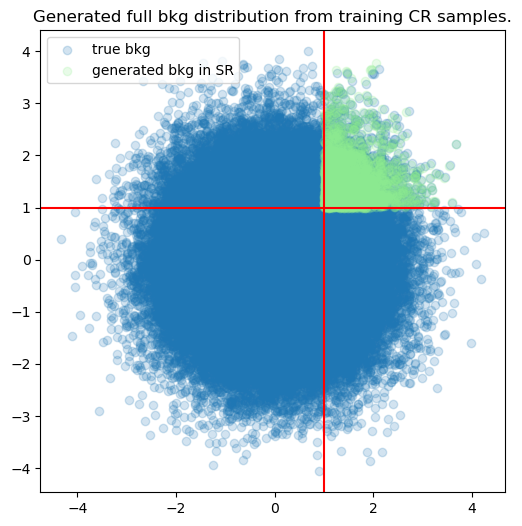

In [11]:
plot_gen_SRfromCR_bkg(samples_gen_SRfromCR_bkg, x1, x2)

### Generate $ y = N( \mu = k\alpha + q\beta,\sigma = 1)$

In [12]:
def Y(k, q, x1, x2):
    return np.random.normal(k*x1 + q*x2, 1, n1).astype(dtype=np.float32)

**y = random**

<function matplotlib.pyplot.close(fig=None)>

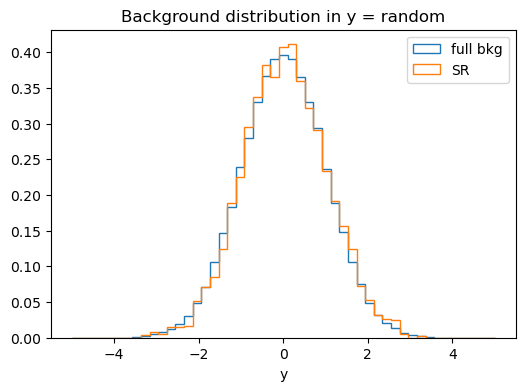

In [13]:
Y_rand = Y(0, 0, x1, x2)
plt.figure(figsize=(6,4))
bins = np.linspace(-5, 5, 50)
plt.hist(Y_rand, bins = bins, density = True, histtype='step', label='full bkg')
plt.hist(Y_rand[mask_SR], bins = bins, density = True, histtype='step', label='SR')
plt.title("Background distribution in y = random")
plt.xlabel("y")
plt.legend()
plt.show
plt.savefig('plots/full_bkg_in_y_random.pdf')
plt.close

In [14]:
cond_CR = np.stack([x1, x2], axis = -1)[mask_CR]

MAF3 = SimpleMAF(num_features = 1, num_cond_features = 2)
MAF3.train(data=Y_rand[mask_CR], cond=cond_CR, n_epochs=50, plot=False)

100%|==========| 50/50 [01:31<00:00,  1.82s/it]


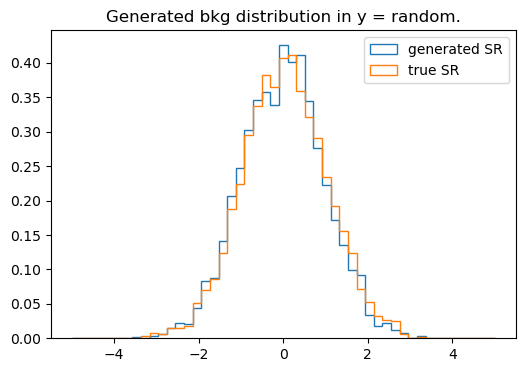

In [15]:
cond_SR = data[mask_SR]
samples_gen_SR_bkg_in_y_random = MAF3.sample(1, cond_SR).reshape(Y_rand[mask_SR].shape)
plot_gen_SR_bkg_in_y_random(samples_gen_SR_bkg_in_y_random, Y_rand[mask_SR])

**Increase dependence of $\alpha$ and $\beta$**

In [159]:
mask_CR = np.logical_not((data[:,0] > 1) & (data[:,1] > 1))
mask_SR = (data[:,0] > 1) & (data[:,1] > 1)

k_list = [0, 0.2, 0.5, 0.8, 1, 1.5, 2]
q_list = [0, 0.2, 0.5, 0.8, 1, 1.5, 2]
Y_list = []
for i in range(len(k_list)):
    Y_list.append(Y(k_list[i], q_list[i], x1, x2))

In [160]:
def MAF2D(k_list, q_list, Y_list, cond):
    MAF_list = []
    samples_list = []
    for i in range(len(k_list)):
        MAF = SimpleMAF(num_features = 1, num_cond_features=2)
        MAF.train(data=Y_list[i][mask_CR], cond=data[mask_CR], n_epochs=50, plot=False)
        samples_list.append(MAF.sample(1, cond[mask_SR]).reshape(Y_list[i][mask_SR].shape))
        del MAF
    return samples_list

In [161]:
samples_list = MAF2D(k_list, q_list, Y_list, data)

100%|==========| 50/50 [01:35<00:00,  1.92s/it]


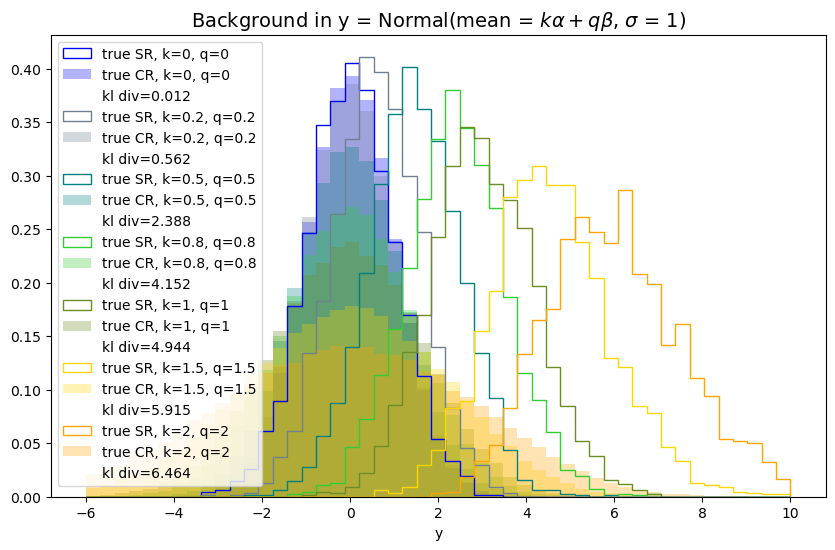

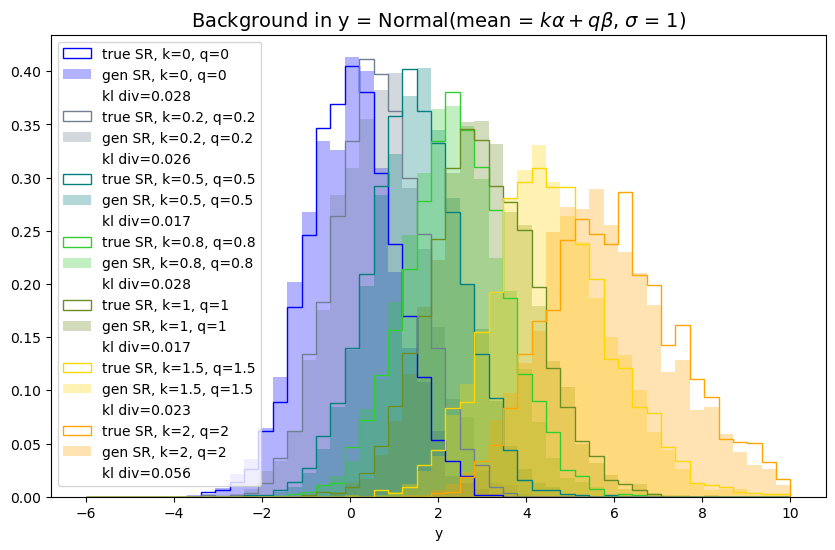

In [164]:
Y_SR_list = []
Y_CR_list = []
Y_gen_list = []

for i in range(len(k_list)):
    Y_SR_list.append(Y_list[i][mask_SR])
    Y_CR_list.append(Y_list[i][mask_CR])
    Y_gen_list.append(samples_list[i])

plot_kwargs = {"title":"Normal(mean = $k\\alpha + q\\beta$, $\sigma$ = 1)", "tag":"2DSR", "ymax":10}
plot_kl_div(Y_SR_list, Y_CR_list, "true SR", "true CR", k_list, q_list, **plot_kwargs)
plot_kl_div(Y_SR_list, Y_gen_list, "true SR", "gen SR", k_list, q_list, **plot_kwargs)

## Toy example 1D

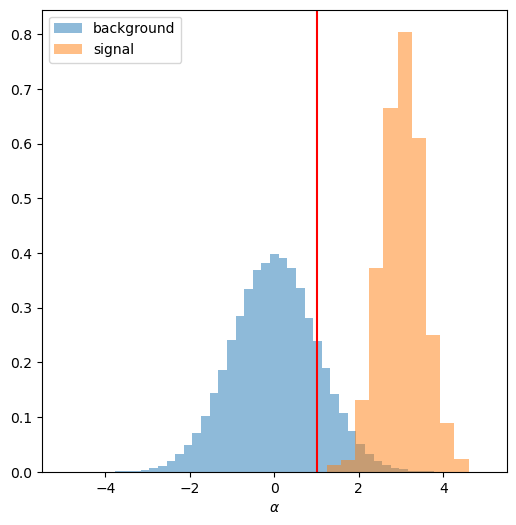

<function matplotlib.pyplot.close(fig=None)>

<Figure size 640x480 with 0 Axes>

In [165]:
plt.figure(figsize=(6,6))
bins = np.linspace(-5, 5, 50)
# Background
data1D = np.random.normal(0, 1, n1).astype(dtype=np.float32)
plt.hist(data1D, bins=bins, density=True, alpha = 0.5, label="background")
# Signal
plt.hist(x3, density=True, alpha = 0.5, label="signal")
plt.xlabel('$\\alpha$')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.show()
plt.savefig('plots/full_bkg_sig_1D.pdf')
plt.close

### Generate $ y = N( \mu = k\alpha,\sigma = 1)$

In [166]:
def Y_1D(k, x1):
    return np.random.normal(k*x1, 1, n1).astype(dtype=np.float32)

In [167]:
mask_CR1D = data1D < 1
mask_SR1D = data1D > 1

k_list = [0, 0.2, 0.5, 0.8, 1, 1.5, 2]
Y1D_list = []
for k in k_list:
    Y1D_list.append(Y_1D(k, data1D))

In [169]:
def MAF1D(k_list, Y_list, cond):
    MAF_list = []
    samples_list = []
    for i in range(len(k_list)):
        MAF = SimpleMAF(num_features = 1, num_cond_features=1)
        MAF.train(data=Y_list[i][mask_CR1D], cond=cond[mask_CR1D], n_epochs=50, plot=False)
        samples_list.append(MAF.sample(1, cond[mask_SR1D].reshape(-1,1)).reshape((cond[mask_SR1D].shape)))
        del MAF
    return samples_list

In [173]:
samples1D_list = MAF1D(k_list, Y1D_list, data1D)

100%|==========| 50/50 [01:25<00:00,  1.70s/it]


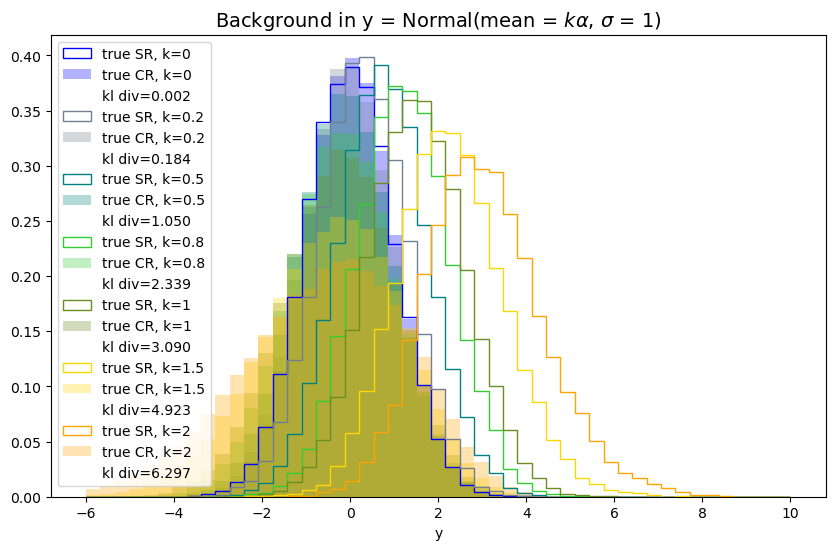

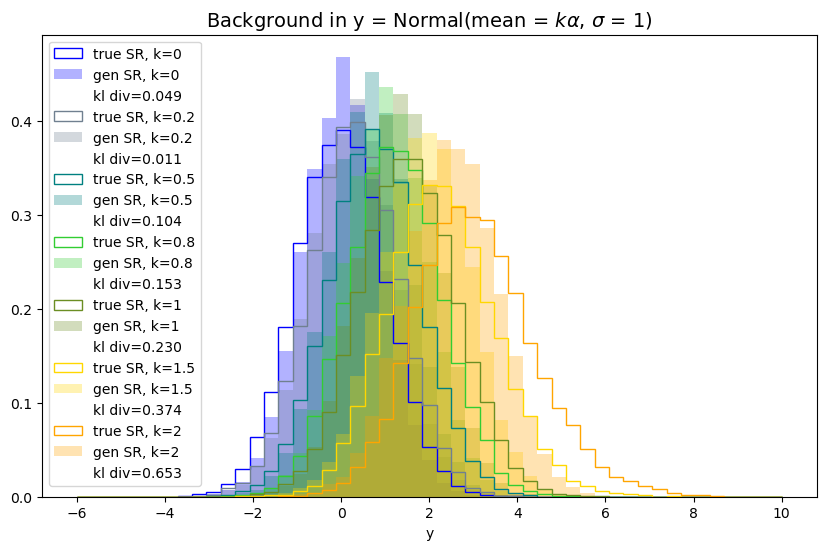

In [175]:
Y1D_SR_list = []
Y1D_CR_list = []
Y1D_gen_list = []

for i in range(len(k_list)):
    Y1D_SR_list.append(Y1D_list[i][mask_SR1D])
    Y1D_CR_list.append(Y1D_list[i][mask_CR1D])
    Y1D_gen_list.append(samples1D_list[i])
    
plot_kwargs = {"title":"Normal(mean = $k\\alpha$, $\sigma$ = 1)", "tag":"1DSR", "ymax":10}
plot_kl_div(Y1D_SR_list, Y1D_CR_list, "true SR", "true CR", k_list, **plot_kwargs)
plot_kl_div(Y1D_SR_list, Y1D_gen_list, "true SR", "gen SR", k_list, **plot_kwargs)

## Break CATHODE

### 1D: $y = N( \mu = k\alpha,\sigma = 1) + k\alpha^2$

In [176]:
def Y2_1D(k, x1):
    return np.random.normal(k*x1, 1, n1).astype(dtype=np.float32) + k*x1*x1

In [178]:
k2_list = [0, 0.5, 1, 1.5]
Y2_1D_list = []
for k in k2_list:
    Y2_1D_list.append(Y2_1D(k, data1D))

In [179]:
samples1D_list2 = MAF1D(k2_list, Y2_1D_list, data1D)

100%|==========| 50/50 [01:25<00:00,  1.71s/it]


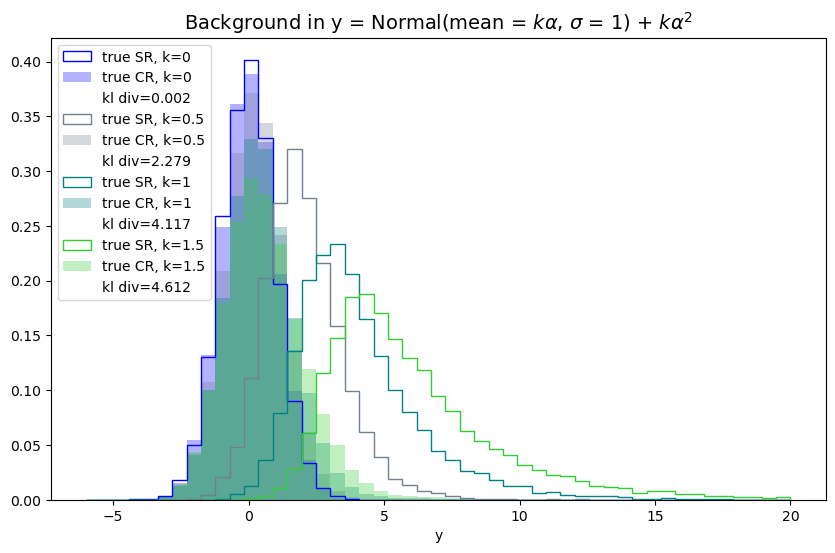

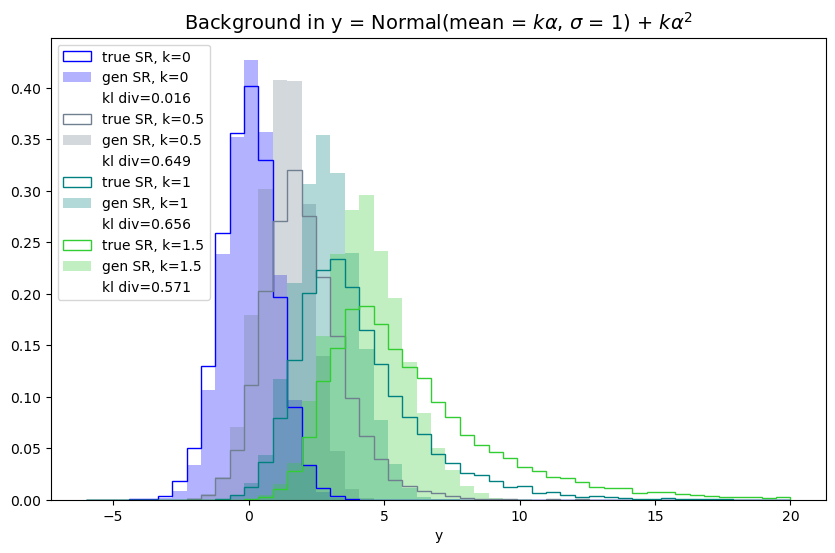

In [181]:
Y2_1D_SR_list = []
Y2_1D_CR_list = []
Y2_1D_gen_list = []

for i in range(len(k2_list)):
    Y2_1D_SR_list.append(Y2_1D_list[i][mask_SR1D])
    Y2_1D_CR_list.append(Y2_1D_list[i][mask_CR1D])
    Y2_1D_gen_list.append(samples1D_list2[i])
    
plot_kwargs = {"title":"Normal(mean = $k\\alpha$, $\sigma$ = 1) + $k\\alpha^2$", "tag":"1DSR_y2", "ymax":20}
plot_kl_div(Y2_1D_SR_list, Y2_1D_CR_list, "true SR", "true CR", k2_list, **plot_kwargs)
plot_kl_div(Y2_1D_SR_list, Y2_1D_gen_list, "true SR", "gen SR", k2_list, **plot_kwargs)

### 2D: $y = N( \mu = k\alpha,\sigma = 1) + k\alpha^2$

In [186]:
def Y2_2D(k,q, x1, x2):
    return np.random.normal(k*x1+q*x2, 1, n1).astype(dtype=np.float32) + k*x1*x1 + + q*x2*x2

Y2_2D_list = []
for i in range(len(k2_list)):
    Y2_2D_list.append(Y2_2D(k2_list[i], k2_list[i], x1, x2))

In [187]:
samples_list2_2D = MAF2D(k2_list, k2_list, Y2_2D_list, data)

100%|==========| 50/50 [01:35<00:00,  1.90s/it]


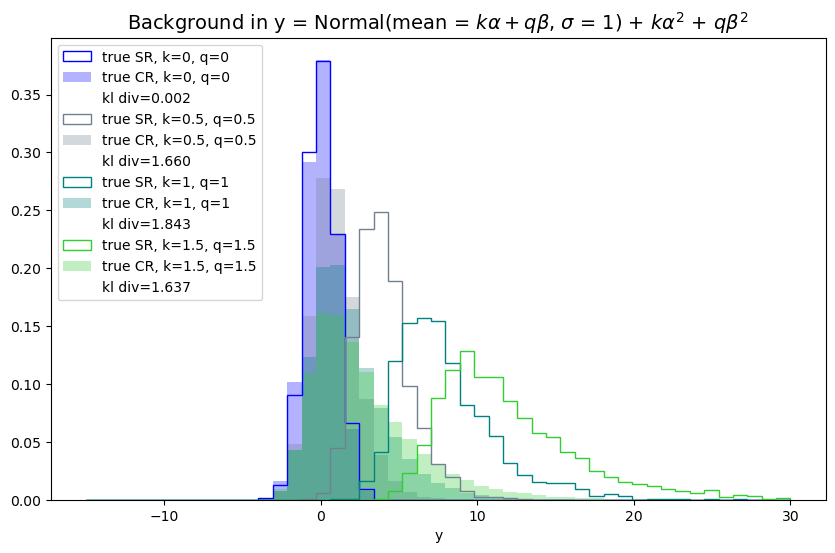

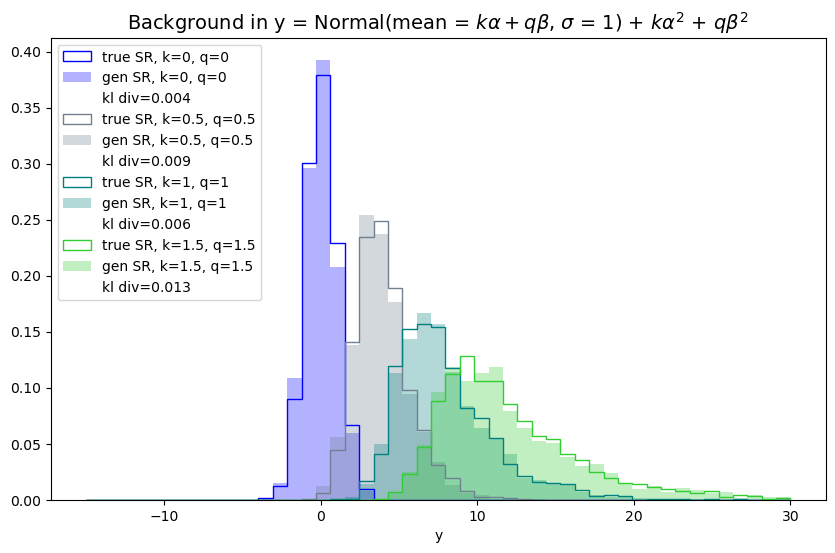

In [193]:
Y2_SR_list = []
Y2_CR_list = []
Y2_gen_list = []

for i in range(len(k2_list)):
    Y2_SR_list.append(Y2_2D_list[i][mask_SR])
    Y2_CR_list.append(Y2_2D_list[i][mask_CR])
    Y2_gen_list.append(samples_list2_2D[i])

plot_kwargs = {"title":"Normal(mean = $k\\alpha + q\\beta$, $\sigma$ = 1) + $k\\alpha^2$ + $q\\beta^2$", "tag":"2DSR_y2", "ymin":-15, "ymax":30}
plot_kl_div(Y2_SR_list, Y2_CR_list, "true SR", "true CR", k2_list, k2_list, **plot_kwargs)
plot_kl_div(Y2_SR_list, Y2_gen_list, "true SR", "gen SR", k2_list, k2_list, **plot_kwargs)